In [1]:
import sys

import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

from os import listdir
from os.path import isfile, join

from scipy import misc
import numpy as np
from PIL import Image

from scipy.stats import mode
import scipy.stats as ss

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html <br>
https://scikit-learn.org/stable/modules/mixture.html

# TASK 2 (Kmeans, GaussianMixture)

## Paths to files

In [2]:
mypath = 'data'
files_list = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files_list = sorted(files_list)

### Example image - to reuse its shape

In [3]:
arr = np.array(Image.open(mypath+'/'+files_list[0]))
arr.shape

(289, 250, 3)

### Loading hands and seg versions

In [4]:
hands = np.empty((len(files_list)//2,)+arr.shape)
hands_seg = np.empty((len(files_list)//2,)+arr.shape[0:2])
model_init = np.array(Image.open(mypath+'/'+files_list[-1]))
for i in range( len(files_list)//2 ):
    hands[i] = np.array(Image.open(mypath+'/'+files_list[i*2]))
    hands_seg[i] = np.array(Image.open(mypath+'/'+files_list[i*2+1]))

### Initial model

In [5]:
model_init = model_init[:,:,0]

### Ploting to see how it looks like

In [6]:
I_red = arr.copy()  # Duplicate image
I_red[:, :, 1] = 0    # Zero out contribution from green
I_red[:, :, 2] = 0    # Zero out contribution from blue

I_green = arr.copy()  # Duplicate image
I_green[:, :, 0] = 0    # Zero out contribution from red
I_green[:, :, 2] = 0 

I_blue = arr.copy()  # Duplicate image
I_blue[:, :, 0] = 0    
I_blue[:, :, 1] = 0 

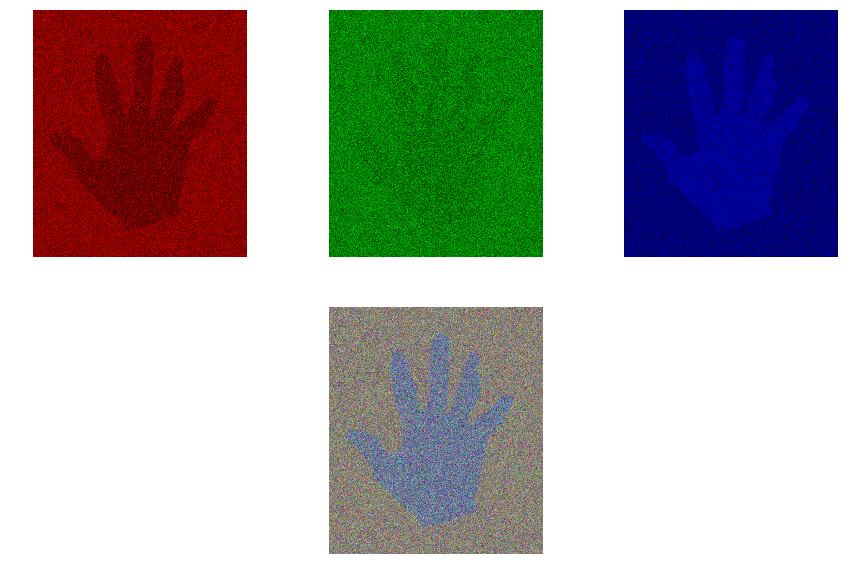

In [7]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(I_red)
plt.axis('off')

plt.subplot(232)
plt.imshow(I_green)
plt.axis('off')

plt.subplot(233)
plt.imshow(I_blue)
plt.axis('off')

plt.subplot(235)
plt.imshow(arr)
plt.axis('off')

plt.show()

### Preparing example to show

In [8]:
def image_f(seg , labels_k, clusters_g, name = None):
    original_shape = hands[seg,:,:,0].shape # so we can reshape the labels later

    clf_k = KMeans(n_clusters=2)
    clf_g = GaussianMixture(n_components = 2)
    #labels = clf.fit_predict(samples).reshape(original_shape)
    #labels_1 = clf.fit(samples).labels_.reshape(original_shape)

    fig = plt.figure(figsize=(15,10))

    samples = np.column_stack([hands[seg,:,:,0].flatten(), hands[seg,:,:,1].flatten(), hands[seg,:,:,2].flatten()])
    labels_k = clf_k.fit_predict(samples).reshape(original_shape)
    labels_g = clf_g.fit_predict(samples).reshape(original_shape)

    if accuracy_score(labels_k.reshape(arr.shape[0]*arr.shape[1]), hands_seg[seg].reshape(arr.shape[0]*arr.shape[1])) < 0.5:
        labels_k = (labels_k-1)*(-1)
    if accuracy_score(labels_g.reshape(arr.shape[0]*arr.shape[1]), hands_seg[seg].reshape(arr.shape[0]*arr.shape[1])) < 0.5:
        labels_g = (labels_g-1)*(-1)
    
    if seg < 10:
        new_seg = '0'+str(seg)
    else:
        new_seg = str(seg)
    plt.subplot(231)
    plt.imshow(labels_k)
    plt.title('Kmeans'+'\n acc = '+str(round(accuracy_score(labels_k.reshape(arr.shape[0]*arr.shape[1]), hands_seg[seg].reshape(arr.shape[0]*arr.shape[1])),4)))
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(hands_seg[seg])
    plt.title('hand_'+new_seg+'_seg.png')
    plt.axis('off')
    plt.subplot(233)
    plt.imshow(labels_g)
    plt.title('GaussMixture'+'\n acc = '+str(round(accuracy_score(labels_g.reshape(arr.shape[0]*arr.shape[1]), hands_seg[seg].reshape(arr.shape[0]*arr.shape[1])),4)))
    plt.axis('off')
    plt.subplot(235)
    plt.title('hand_'+new_seg+'.png')
    plt.imshow(np.array(Image.open(mypath+'/hand_'+new_seg+'.png')))
    plt.axis('off')
    if name:
        plt.savefig(name+'.png', bbox_inches='tight')
    else:
        plt.show()

## K-means

In [9]:
kmeans = KMeans(n_clusters = 2)

In [10]:
clusters_arr = np.zeros(hands.shape[0:3])

original_shape = hands[0,:,:,0].shape # so we can reshape the labels later

for i in range(hands.shape[0]):
    samples = np.column_stack([hands[i,:,:,0].flatten(), hands[i,:,:,1].flatten(), hands[i,:,:,2].flatten()])
    clusters_arr[i] = kmeans.fit_predict(samples).reshape(original_shape)

## GaussianMixture

In [11]:
gmm = GaussianMixture(n_components = 2)

In [12]:
labels_arr = np.zeros(hands.shape[0:3])
for i in range(hands.shape[0]):
    samples = np.column_stack([hands[i,:,:,0].flatten(), hands[i,:,:,1].flatten(), hands[i,:,:,2].flatten()])
    labels_arr[i] = gmm.fit_predict(samples).reshape(original_shape)

## Compare accuracy

In [13]:
comp = np.zeros((labels_arr.shape[0],2))

In [14]:
for i in range(labels_arr.shape[0]):
    comp[i,0] = accuracy_score(clusters_arr[i].reshape(arr.shape[0]*arr.shape[1]), hands_seg[i].reshape(arr.shape[0]*arr.shape[1]))
    comp[i,1] = accuracy_score(labels_arr[i].reshape(arr.shape[0]*arr.shape[1]), hands_seg[i].reshape(arr.shape[0]*arr.shape[1]))

In [15]:
indx = np.where(comp<0.5)
comp[comp<0.5] = 1-comp[comp<0.5] 

In [16]:
indy = np.concatenate((np.transpose([indx[0]]),np.transpose([indx[1]])),axis=-1)
indx_k = indy[indy[:,1]<1]
indx_g = indy[indy[:,1]>0]

#### Changing labels (for  acc<0.5 change to 1-acc) (becuse what is 0 should be 1 and vice versa)

In [17]:
for k in indx_k:
    clusters_arr[k[0]] = (clusters_arr[k[0]]-1)*(-1)
for g in indx_g:
    labels_arr[g[0]] = (labels_arr[g[0]]-1)*(-1)

#### Changing to dataframe

In [18]:
comp_df = pd.DataFrame(data=comp) 
comp_df.columns = ['Kmeans','Gauss']

### K-means avg values bigger than GMM avg values

In [19]:
(comp_df.Gauss<comp_df.Kmeans).value_counts()

False    49
True      1
dtype: int64

So GMM gives us better results than K-means

https://towardsdatascience.com/introduction-to-image-segmentation-with-k-means-clustering-83fd0a9e2fc3

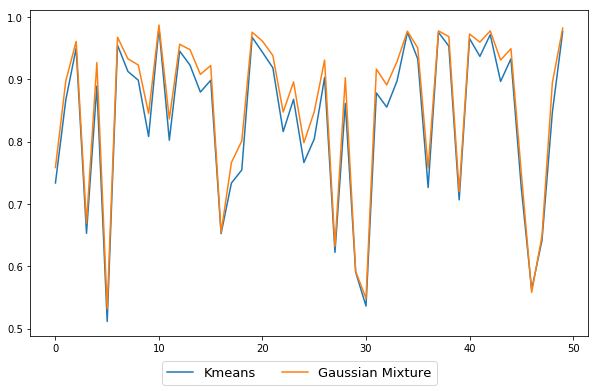

In [20]:
plt.figure(figsize=(10,6))
plt.plot(comp_df['Kmeans'])
plt.plot(comp_df['Gauss'])
plt.figlegend( ['Kmeans', 'Gaussian Mixture'], loc = 'lower center', ncol=2, labelspacing=0., fontsize=13 )
plt.show()

### initialize centers for Kmeans and GM

In [21]:
def init_KMeans_GM(X,T):
    im_init = np.zeros((50,2,3))
    covar = np.zeros((50,2,3,3))

    # Generate indices for coordinates inside circle containing foreground pixels
    x = np.arange(0, len(T[0][0]))
    y = np.arange(0, len(T[0]))
    center = [int(len(T[0][0])/2), int(len(T[0])/2 + 25)]
    r = 30
    mask1 = (x[np.newaxis,:] - center[0])**2 + (y[:,np.newaxis] - center[1])**2 < r**2

    # Generate indices for coordinates outside rectangle containing foreground pixels
    len_X, len_Y = len(T[0][0]), len(T[0])
    mask0 = np.ones(T[0].shape, dtype=bool)
    mask0[15:(len_Y-15), 15:(len_X-15)] = False

    for i in range(len(X)):
        temp1 = (X[i][mask1])
        temp0 = (X[i][mask0])
        im_init[i][0] = np.average(temp0, axis=0)
        im_init[i][1] = np.average(temp1, axis=0)
        covar[i][0] = np.cov(temp0, rowvar=False)
        covar[i][1] = np.cov(temp1, rowvar=False)

    return im_init, covar

In [22]:
means, covs = init_KMeans_GM(hands, hands_seg)

### Initialize Kmeans

In [23]:
clusters_arr_init = np.zeros(hands.shape[0:3])

original_shape = hands[0,:,:,0].shape # so we can reshape the labels later

for i in range(hands.shape[0]):
    kmeans = KMeans(n_clusters = 2, init = means[i], n_init = 1)
    samples = np.column_stack([hands[i,:,:,0].flatten(), hands[i,:,:,1].flatten(), hands[i,:,:,2].flatten()])
    clusters_arr_init[i] = kmeans.fit_predict(samples).reshape(original_shape)

### Initialize GM

In [24]:
labels_arr_init = np.zeros(hands.shape[0:3])

for i in range(hands.shape[0]):
    gmm = GaussianMixture(n_components = 2, means_init = means[i])
    samples = np.column_stack([hands[i,:,:,0].flatten(), hands[i,:,:,1].flatten(), hands[i,:,:,2].flatten()])
    labels_arr_init[i] = gmm.fit_predict(samples).reshape(original_shape)

### Compare accuracy of initialized

In [25]:
comp_init = np.zeros((labels_arr_init.shape[0],2))

In [26]:
for i in range(labels_arr.shape[0]):
    comp_init[i,0] = accuracy_score(clusters_arr_init[i].reshape(arr.shape[0]*arr.shape[1]), hands_seg[i].reshape(arr.shape[0]*arr.shape[1]))
    comp_init[i,1] = accuracy_score(labels_arr_init[i].reshape(arr.shape[0]*arr.shape[1]), hands_seg[i].reshape(arr.shape[0]*arr.shape[1]))

In [27]:
comp_init_df = pd.DataFrame(data=comp_init) 
comp_init_df.columns = ['Kmeans','Gauss']

(comp_init_df.Gauss<comp_init_df.Kmeans).value_counts()

False    50
dtype: int64

In [28]:
print('worst Kmenas:',comp_init_df['Kmeans'].idxmin())
print('worst Gauss:',comp_init_df['Gauss'].idxmin())
print('max Kmenas:',comp_init_df['Kmeans'].idxmax())
print('max Gauss:',comp_init_df['Gauss'].idxmax())

worst Kmenas: 5
worst Gauss: 46
max Kmenas: 10
max Gauss: 10


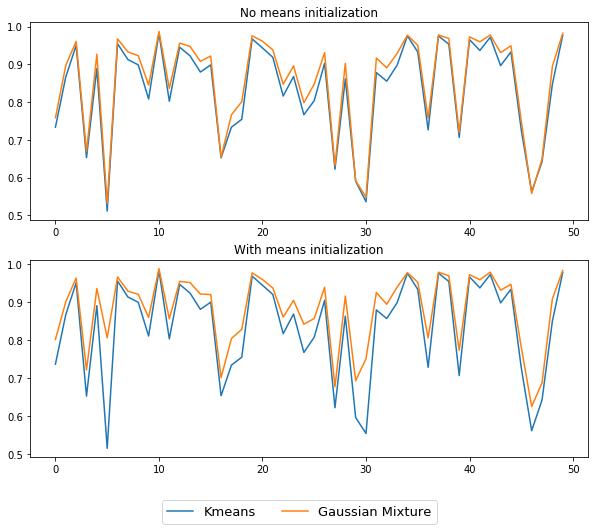

In [29]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(comp_df['Kmeans'])
plt.plot(comp_df['Gauss'])
plt.title('No means initialization')
plt.subplot(212)
plt.plot(comp_init_df['Kmeans'])
plt.plot(comp_init_df['Gauss'])
plt.title('With means initialization')
plt.figlegend( ['Kmeans', 'Gaussian Mixture'], loc = 'lower center', ncol=2, labelspacing=0., fontsize=13 )
plt.show()

# TASK 3 (EM algorithm)

In [30]:
means, covs = init_KMeans_GM(hands, hands_seg)

### Plot the model_init

225
30


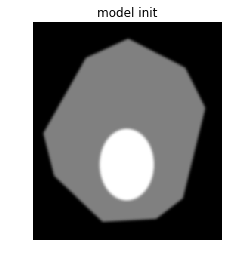

In [31]:
plt.title('model init')
plt.imshow(model_init, cmap='gray')
plt.axis('off')
plt.plot()
print(np.max(model_init))
print(np.min(model_init))

### alphas

In [32]:
a = np.ones(((len(hands),)+hands[0].shape[0:2]))

### probabilities functions

In [33]:
def p_s(u, s_i):
    val = np.exp(u*s_i)/(1 + np.exp(u))
    #val = val.reshape(val.shape[0],val.shape[1],1)
    return val
def p_x_s(x, mean_l_si, cov_l_si):
    y = x.reshape(x.shape[0]*x.shape[1],x.shape[2])
    val = ss.multivariate_normal.pdf(y, mean = mean_l_si, cov = cov_l_si)
    return val.reshape(x.shape[0], x.shape[1])    

### u initialization and variables for meana ans covariances

In [34]:
p_s1 = model_init/255
u = np.log(p_s1/(1-p_s1))
#foreground == 1, background == 0
# means, covs
mean_1 = means[:,1,:]
mean_0 = means[:,0,:]
cov_1 = covs[:,1,:,:]
cov_0 = covs[:,0,:,:]

### accuracy

In [35]:
acc = 0

### algorithm

0 0.9384
1 0.977


KeyboardInterrupt: 

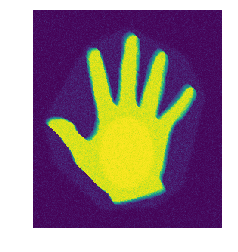

In [36]:
j = 0
ll = 1
change = 100
while change > 0.00001:
    m = hands.shape[0]
    ##### E-step #####
    for l in range(m):
        a_top = (p_x_s(hands[l], mean_1[l], cov_1[l])*p_s(u, 1))
        a_bottom = ( p_x_s(hands[l], mean_1[l], cov_1[l])*p_s(u, 1) + p_x_s(hands[l], mean_0[l], cov_0[l])*p_s(u, 0))
        a[l] = a_top/a_bottom
    ##### M-step #####
    # max u
    u = np.log( np.sum(a,axis=0)/m /(1-np.sum(a,axis=0)/m) )
    # max theta_1, theta_0 
    tmp_acc = 0
    ll_l = ll
    ll = 0
    for l in range(m):
        hand = hands[l]
        labels = hands_seg[l].reshape(hand.shape[0]*hand.shape[1])
        hand = hand.reshape(hand.shape[0]*hand.shape[1], hand.shape[2])
        a_i = a[l]
        a_i = a_i.reshape(a_i.shape[0]*a_i.shape[1])
        y = a_i.copy()
        y[y>=0.5] = 1
        y[y<0.5] = 0
        tmp_acc +=  accuracy_score(labels, y)
        mean_1[l] = np.average(hand,axis=0,weights=a_i)
        mean_0[l] = np.average(hand,axis=0,weights=1-a_i)
        cov_1[l] = np.cov(hand, rowvar=False, aweights=a_i)
        cov_0[l] = np.cov(hand, rowvar=False, aweights=1-a_i)
        ll += np.sum(np.log(p_x_s(hands[l], mean_0[l], cov_0[l])*p_s(u, 0) + 
                           p_x_s(hands[l], mean_1[l], cov_1[l])*p_s(u, 1)))
    acc = tmp_acc/m
    ll /= m
    change = abs((ll_l-ll)/ll_l)
    print(j,round(acc,4))
    #plt.imshow(p_s(u,1))
    #plt.axis('off')
    #plt.savefig('pu'+str(j)+'.png', bbox_inches='tight')
    j += 1

In [ ]:
acc_em = np.zeros(m)
for i in range(a.shape[0]):
    y = a[i].copy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    acc_em[i] = accuracy_score(y.reshape(arr.shape[0]*arr.shape[1]), hands_seg[i].reshape(arr.shape[0]*arr.shape[1]))

In [ ]:
plt.figure(figsize=(10,6))
#plt.plot(comp_df['Kmeans'])
#plt.plot(comp_df['Gauss'])
plt.plot(comp_init_df['Kmeans'])
plt.plot(comp_init_df['Gauss'])
plt.plot(acc_em)
plt.title('Acc comparison')
plt.ylim(bottom=0.4)
plt.ylabel('Accuracy')
plt.xlabel('Image number')
plt.legend( [#r'Kmeans $\mu_{rand}$', 
             #r'Gaussian Mixture $\mu_{rand}', 
             r'Kmeans $\mu_{init}$', 
             r'Gaussian Mixture $\mu_{init}$', 
             'Expectation-Maximization']
            , loc = 'lower center', ncol=3, fontsize = 12)
plt.savefig('Acc_comparison_all.png', bbox_inches='tight')

In [ ]:
T = hands_seg
x = np.arange(0, len(T[0][0]))
y = np.arange(0, len(T[0]))
center = [int(len(T[0][0])/2), int(len(T[0])/2 + 25)]
r = 30
mask1 = (x[np.newaxis,:] - center[0])**2 + (y[:,np.newaxis] - center[1])**2 < r**2

# Generate indices for coordinates outside rectangle containing foreground pixels
len_X, len_Y = len(T[0][0]), len(T[0])
mask0 = np.ones(T[0].shape, dtype=bool)
mask0[15:(len_Y-15), 15:(len_X-15)] = False

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mask0)#, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(mask1)#, cmap='gray')
plt.axis('off')
plt.savefig('Borders.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(p_s(u, 1), cmap='gray')
plt.axis('off')
plt.title(r'Output for $p_u(s_i = 1)$', fontsize = 11)
plt.savefig('pu.png', bbox_inches='tight')

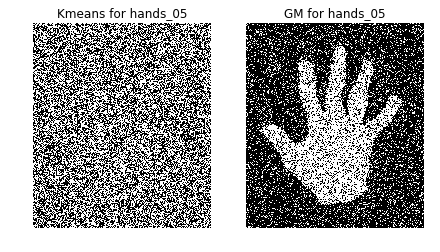

In [41]:
plt.figure(figsize=(7,14))
plt.subplot(121)
plt.title('Kmeans for hands_05')
plt.imshow(clusters_arr_init[5], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('GM for hands_05')
plt.imshow(labels_arr_init[5], cmap='gray')
plt.axis('off')
plt.savefig('seg_hand_05.png', bbox_inches='tight')

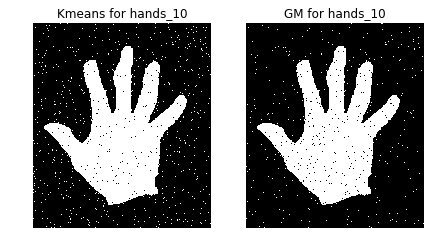

In [42]:
plt.figure(figsize=(7,14))
plt.subplot(121)
plt.title('Kmeans for hands_10')
plt.imshow(clusters_arr_init[10], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('GM for hands_10')
plt.imshow(labels_arr_init[10], cmap='gray')
plt.axis('off')
plt.savefig('seg_hand_10.png', bbox_inches='tight')

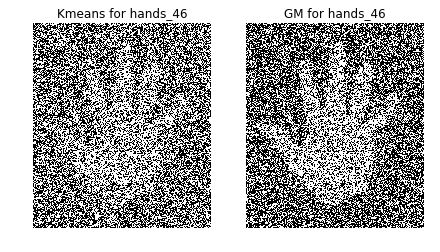

In [43]:
plt.figure(figsize=(7,14))
plt.subplot(121)
plt.title('Kmeans for hands_46')
plt.imshow(clusters_arr_init[46], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('GM for hands_46')
plt.imshow(labels_arr_init[46], cmap='gray')
plt.axis('off')
plt.savefig('seg_hand_46.png', bbox_inches='tight')

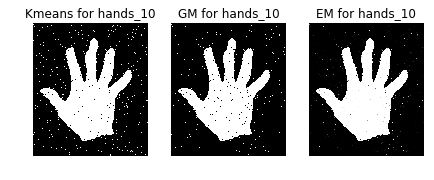

In [46]:
plt.figure(figsize=(7,21))
plt.subplot(131)
plt.title('Kmeans for hands_10')
plt.imshow(clusters_arr_init[10], cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('GM for hands_10')
plt.imshow(labels_arr_init[10], cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('EM for hands_10')
plt.imshow(a[10], cmap='gray')
plt.axis('off')
plt.savefig('seg_hand_10_EM.png', bbox_inches='tight')

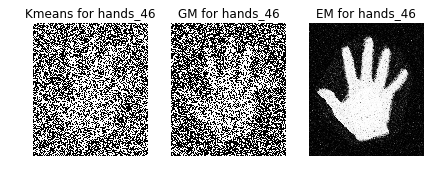

In [48]:
plt.figure(figsize=(7,21))
plt.subplot(131)
plt.title('Kmeans for hands_46')
plt.imshow(clusters_arr_init[46], cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('GM for hands_46')
plt.imshow(labels_arr_init[46], cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('EM for hands_46')
plt.imshow(a[46], cmap='gray')
plt.axis('off')
plt.savefig('seg_hand_46_EM.png', bbox_inches='tight')